# Introduction

A simple **Chat-with-Multi PDFs / Docs** app for **Retrieval-Augmented Generation (RAG)**.  
It allows you to ask questions about the contents of PDFs and DOC files, and the app will provide relevant responses.

![Chatbot Diagram](../src/images/graphWorkFlow.jpg)

This app is built using [**LangGraph**](https://www.langchain.com/langgraph) and [**LangChain**](https://www.langchain.com/).



In [1]:
# set Setting
import os 
import dotenv
from langchain.chat_models import init_chat_model
os.environ['GOOGLE_API_KEY'] = dotenv.get_key(key_to_get='GOOGLE_API_KEY', dotenv_path='.env')
llm = init_chat_model(model = 'gemini-2.5-flash' , model_provider='google-genai')

# 1. Preprocess documents

- In this step we read files to get the full text and split them into small chunks and embed them to store in Vectore DataBase.


##### 1) Reading Files using PyPDF2 to extract text from pdf

In [2]:
from PyPDF2 import PdfReader

def get_content_pages(files:  list[str]) -> str:
    """Read PDF or TXT files and return their combined text"""
    ftext = ""
    for file_path in files:
        if file_path.lower().endswith(".pdf"):
            pdf_loader = PdfReader(file_path)
            for page in pdf_loader.pages:
                ftext += page.extract_text() or ""  
        else:
            with open(file_path, "r", encoding="utf-8") as f:
                ftext += f.read()
        ftext += "\n"
    return ftext



##### 2) Split Full text into small chunks

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

def split_chunks(text : str , chunk_size :int = 600, chunk_overlap : int = 50) :
    """Split to small and overla chunks"""
    splitter= RecursiveCharacterTextSplitter("\n", chunk_size =chunk_size , 
                                         chunk_overlap =chunk_overlap)
    chunks = splitter.split_text(text)

    return chunks


##### 3) Initialize Vector Database

1. Generate embeddings from chunks using the **[MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)** model from SentenceTransformers.

2. Store the embeddings in a vector database using **Chroma** from LangChain.

In [4]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import InMemoryVectorStore


def create_vectorDB(chunks : list[str] ,
                    embedding_name  : str = "sentence-transformers/all-MiniLM-L6-v2" ) : 
    """Generate and store embedding of chunks into vector database"""
    embedding_model = HuggingFaceEmbeddings(model_name = embedding_name)
    vectordb = InMemoryVectorStore.from_texts(chunks , embedding_model)
    return vectordb

##### 4) concate components together


In [5]:
def ProcessDocuments(files:list[str]) :
    """concat all together""" 
    
    content = get_content_pages(files=files)
    chunks = split_chunks(content)
    vectorDB = create_vectorDB(chunks)
    return vectorDB , chunks


In [6]:
# testing functions
pdfs = [os.path.join('data' , x) for x in os.listdir("data")]  #pdf paths
vector_db ,chunks = ProcessDocuments(pdfs) 


C:\Users\szeya\AppData\Local\Temp\ipykernel_25508\2406254441.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name = embedding_name)
c:\Users\szeya\miniconda3\envs\chat\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
len(chunks)

626

In [8]:
query = "transformer encoder" 
similar_docs = vector_db.similarity_search(query, k=3)
for i, doc in enumerate(similar_docs):
    print("---" * 15, f"*{i+1}*", "---" * 15)

    print(doc.page_content)

--------------------------------------------- *1* ---------------------------------------------
E1+
E2+
E3+
E4+
E5+……………
U
U
U
U…logitslogitslogitslogitslogits
Figure 9.1 The architecture of a (left-to-right) transformer, showing how each input token
get encoded, passed through a set of stacked transformer blocks, and then a language model
head that predicts the next token.
Fig. 9.1 sketches the transformer architecture. A transformer has three major
components. At the center are columns of transformer blocks . Each block is a
multilayer network (a multi-head attention layer, feedforward networks and layer
--------------------------------------------- *2* ---------------------------------------------
11.6 Summary
This chapter has introduced the bidirectional encoder and the masked language
model . Here’s a summary of the main points that we covered:
• Bidirectional encoders can be used to generate contextualized representations
of input embeddings using the entire input context.
• Pret

# 2. Generate a Retriever Tool using LangChain

- Use `create_retriever_tool` from **LangChain** to generate a retriever tool from the vector database.

##### 1) retriever_tool Function

In [9]:
from langchain.tools.retriever import create_retriever_tool 

retriver = vector_db.as_retriever()
retrivertool = create_retriever_tool(retriver , 
                                     "retriever_tool" ,
                                     "Search and return information about input context" )

print(retrivertool.invoke({"query": query}))


E1+
E2+
E3+
E4+
E5+……………
U
U
U
U…logitslogitslogitslogitslogits
Figure 9.1 The architecture of a (left-to-right) transformer, showing how each input token
get encoded, passed through a set of stacked transformer blocks, and then a language model
head that predicts the next token.
Fig. 9.1 sketches the transformer architecture. A transformer has three major
components. At the center are columns of transformer blocks . Each block is a
multilayer network (a multi-head attention layer, feedforward networks and layer

11.6 Summary
This chapter has introduced the bidirectional encoder and the masked language
model . Here’s a summary of the main points that we covered:
• Bidirectional encoders can be used to generate contextualized representations
of input embeddings using the entire input context.
• Pretrained language models based on bidirectional encoders can be learned
using a masked language model objective where a model is trained to guess
the missing information from an input.
• The ve

In [10]:
from langgraph.prebuilt import create_react_agent

RetriverAgent = create_react_agent(
            llm,
            tools=[retrivertool],
            name="RetriverAgent",
            prompt=(
                "You are a retriever agent.\n"
                "- Always call the retriever_tool with the user query.\n"
                "- Return ONLY the page_content of the retrieved documents.\n"
                "- Do not summarize or rephrase.\n"
                "- Don't return repeated retrieved chunks.\n"
                "- If you didn't find similar text return 'I can't find it'"
            )
        )


# 3. Detect Language and Dialect

##### 1) Detect Language using Prompt Template with structure ouput and Dialect if the query language is ar

#####  Detect Arabic dialect

- Using [IbrahimAmin/marbertv2-arabic-written-dialect-classifier](https://huggingface.co/IbrahimAmin/marbertv2-arabic-written-dialect-classifier)  
- The model predicts one of **5 Arabic dialects**:

| Code | Dialect | Region / Notes |
|------|---------|----------------|
| MAGHREB | Maghreb dialect | Northwest Africa (Morocco, Algeria, Tunisia, Libya, Mauritania) |
| LEV     | Levantine dialect | Lebanon, Syria, Jordan, Palestine |
| MSA     | Modern Standard Arabic | Formal Arabic (books, news, official use) |
| GLF     | Gulf dialect | Saudi Arabia, UAE, Kuwait, Bahrain, Qatar, Oman |
| EGY     | Egyptian dialect | Egypt |



In [11]:
from pydantic import Field, BaseModel
from langgraph.graph import MessagesState
from langchain_core.prompts import PromptTemplate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

class LanguageDetector(BaseModel):
    language: str = Field(
        description="Detected language of the question, represented in a two-character ISO 639-1 code."
    )


dialect_model_name = "IbrahimAmin/marbertv2-arabic-written-dialect-classifier"

dialect_pipeline = pipeline(
    "text-classification",
    model=AutoModelForSequenceClassification.from_pretrained(dialect_model_name),
    tokenizer=AutoTokenizer.from_pretrained(dialect_model_name),
)



def detecting_language(state: MessagesState):
    
    question = state["messages"][0].content
    detectionmodel = llm.with_structured_output(LanguageDetector)

    LANGUAGE_DETECTOR_TEMPLATE = "\n\n".join([
        "You are a language detector assessing to return the language of the question from a user.",
        "Here is the user question: {question}",
        "# Instructions:",
        "- Return only the two-character ISO 639-1 code for the language.",
        "- Base detection on the language of the question itself (its structure and wording), not on individual foreign words inside it.",
        "- Focus especially on the interrogative word (e.g., what, how, من, ماذا) and the main verb or auxiliary verb."
    ])


    detection_prompt = PromptTemplate(
        template=LANGUAGE_DETECTOR_TEMPLATE,
        input_variables=["question"]
    )

    prompt = detection_prompt.format(question=question)
    response: LanguageDetector = detectionmodel.invoke(prompt)

    # dialect
    dialect = None
    if response.language == "ar":
        preds = dialect_pipeline(question, top_k=None)
        if preds:
            best = max(preds, key=lambda x: x["score"])
            dialect = best["label"]

    return {"detected_lang": response.language, "dialect": dialect}


Device set to use cpu


In [12]:
#Test
from langchain_core.messages import HumanMessage
import time

examples = [
    ("Arabic Question", MessagesState(messages=[HumanMessage(content="ما هي أنواع Transformer؟")])),
    ("English Question", MessagesState(messages=[HumanMessage(content="What are the types of Transformer?")])),
    ("French Question", MessagesState(messages=[HumanMessage(content="Qu'est-ce qu'un transformateur?")])),
    ("Spanish Question", MessagesState(messages=[HumanMessage(content="¿Cuáles son los tipos de transformadores?")])),
    ("German Question", MessagesState(messages=[HumanMessage(content="Welche Arten von Transformatoren gibt es?")])) ,
]


for name, state in examples:
    result = detecting_language(state)
    print(f"{name}: {result}")
    print("-" * 50)
    time.sleep(3)

Arabic Question: {'detected_lang': 'ar', 'dialect': 'MSA'}
--------------------------------------------------
English Question: {'detected_lang': 'en', 'dialect': None}
--------------------------------------------------
French Question: {'detected_lang': 'fr', 'dialect': None}
--------------------------------------------------
Spanish Question: {'detected_lang': 'es', 'dialect': None}
--------------------------------------------------
German Question: {'detected_lang': 'de', 'dialect': None}
--------------------------------------------------


In [13]:
#Test

import time
examples = [
    ("EGY Example", MessagesState(messages=[HumanMessage(content="ازيك يصحبي قولي انواع l")])),
    ("LEV Example 2", MessagesState(messages=[HumanMessage(content="عامل اي يازلمي اليوم ممكن تقولي types of ML")])),
    ("GLF Example", MessagesState(messages=[HumanMessage(content="شلونك يا طويل العمر؟ ممكن تقول لي examples of ML")])),
    ("LEV Example", MessagesState(messages=[HumanMessage(content="كيفك يا زلمي؟ شو الأخبار؟ give me types of ML")])),
    ("MSA Example", MessagesState(messages=[HumanMessage(content="ما هي أنواع   ML techniques؟")]))
]


for name, state in examples:
    result = detecting_language(state)
    print(f"{name}: {result}")
    print("-" * 50)
    time.sleep(3)

EGY Example: {'detected_lang': 'ar', 'dialect': 'EGY'}
--------------------------------------------------
LEV Example 2: {'detected_lang': 'ar', 'dialect': 'LEV'}
--------------------------------------------------
GLF Example: {'detected_lang': 'ar', 'dialect': 'GLF'}
--------------------------------------------------
LEV Example: {'detected_lang': 'ar', 'dialect': 'LEV'}
--------------------------------------------------
MSA Example: {'detected_lang': 'ar', 'dialect': 'MSA'}
--------------------------------------------------


##### 2) Translate Query to English

In [14]:
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState

def TranslateQuery(state :MessagesState):
    "Machine Translation to translate Queries to english text"
    question = state['messages'][0].content

    msg_prompt = f"""
                    You are a Machine Translation (MT) system.
                    Your task: translate the user question to English text.

                    Instructions:
                    1. Translate the question to English as accurately as possible.
                    2. Do not add explanations, comments, or extra content.
                    3. Do not attempt to clarify or modify the meaning.
                    4. Keep the original meaning exactly.

                    User question: "{question}"
                    """

    prompt_msg_template = PromptTemplate(
        template=msg_prompt,
        input_variables=['question']
    )

    resonong = llm.invoke([{'role': 'user', 'content': prompt_msg_template.format(question=question)}])

    return {'messages': [HumanMessage(content=resonong.content)]}


In [15]:
from langchain_core.messages import convert_to_messages

input_state = {
    "messages": convert_to_messages([
        {"role": "user", "content": "تقدر تفرق بين انواع transformers "}
    ])
}


response = TranslateQuery(input_state)
response["messages"][-1].pretty_print()

================================ Human Message =================================

Can you differentiate between types of transformers?


# 4. Grader
- Grander is a score computed from llm to determine whether the retrieved documents are relevant to the question.

In [16]:
from pydantic import BaseModel , Field
from typing import Literal
from langchain_core.messages import AIMessage


class GraderDocument(BaseModel):
    """Grade documents using a binary score for relevance check."""
    binary_score : str = Field(description= "Relevance score: 'yes' if relevant, or 'no' if not relevant")


def GraderDocumentAgent(state:MessagesState)-> Literal['Chit-ChatAgent' ,'AnswerAgent'] :
    question = state['messages'][0].content
    context = state['messages'][-1].content

      
    gradermodel = llm.with_structured_output(GraderDocument)
    
    GRADE_PROMPT = '\n\n'.join([
    "You are a grader assessing relevance of a retrieved document to a user question.",
    "Here is the retrieved document: \n\n {context}",
    "Here is the user question: {question}",
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant",
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."])
    
    prompt = PromptTemplate(template= GRADE_PROMPT , input_variables=['question', 'context'])
    
    prompt_template = prompt.format(question = question , context = context)
    response =  gradermodel.invoke(
        [HumanMessage(content=prompt_template) ]
    )

    score = response.binary_score
    
    if score == 'yes' :
        return "AnswerAgent"
    else : 
        return 'Chit-ChatAgent'
    




In [17]:
# test
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does machine learning?",
            },
            
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retriever_tool",
                        "args": {"query": "Supervised learning, Unsupervised learning, Reinforcement learning."},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}


GraderDocumentAgent(input)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 57
}
].


'Chit-ChatAgent'

In [18]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does machine learning?",
            },
            
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retriever_tool",
                        "args": {"query": "Supervised learning, Unsupervised learning, Reinforcement learning."},
                    }
                ],
            },
            {"role": "tool", 
             "content": """Machine learning is a field of artificial intelligence that focuses on building models that can learn from data and make predictions or decisions without being explicitly programmed. 
                            It is commonly used for tasks likelassification, regression, and pattern recognition. """, 
            "tool_call_id": "1"},
        ]
    )
}


GraderDocumentAgent(input)

'AnswerAgent'

# 5. Generate an answer


In [19]:
def GenerateAnswer(state:MessagesState) :
    """Generate an answer."""

    GENERATE_PROMPT ="\n".join([
    "You are an assistant for question-answering tasks. ",
    "Use the following pieces of retrieved context to answer the question. ",
    "Answer as many questions as possible and make it a simple temporary one"
    "- Generate english text only"
    "Question: {question} \n",
    "Context: {context}" ]
    )

    question = state.get("translated_query", state["messages"][0].content)
    print(
      "********************************" , question , "+++++++++++++++++++++++++"
    )
    context = state["messages"][-1].content

    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm.invoke([{"role": "user", 
                            "content": prompt}])
    
    return {"messages": [response]}

In [20]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What are the main types of machine learning?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_tool",
                        "args": {"query": "types of machine learning"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Machine learning is commonly categorized into three main types: supervised learning, unsupervised learning, and reinforcement learning.",
                "tool_call_id": "1",
            },
        ]
    )
}

response = GenerateAnswer(input)
response["messages"][-1].pretty_print()

******************************** What are the main types of machine learning? +++++++++++++++++++++++++
================================== Ai Message ==================================

The main types of machine learning are:
*   Supervised learning
*   Unsupervised learning
*   Reinforcement learning


# 6. Chit-Chat Agent

In [21]:
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage

def chitChatAgent(state):
    question = state['messages'][0].content

    msg_prompt = f"""
        You are a Chit-Chat Assistant.
        Your task: reply politely when the context not related to  a user question so follow Instructions to senf a chit chat message.
        
        Instructions:
        1. Start by apologizing that you don't fully understand the question.
        2. Try to clarify by highlighting key words from the user's question.
        3. Use short, simple sentences to suggest that the user rephrase their question.
        5. shorts apologizing messages

        User question: "{question}"
        """

    prompt_msg_template = PromptTemplate(
        template=msg_prompt,
        input_variables=['question']
    )

    resonong = llm.invoke([{'role': 'user', 'content': prompt_msg_template.format(question=question)}])

    return {'messages': [AIMessage(content=resonong.content)]}


In [22]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "where salaj play in zamilk",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_tool",
                        "args": {"query": "classification of machine learning"},
                    }
                ],
            },
            {"role": "tool", "content": "Supervised, Unsupervised, Reinforcement Learning", "tool_call_id": "1"},
        ]
    )
}

response = chitChatAgent(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

I apologize, but I'm not entirely sure I understand your question.
Are you asking about "Salaj" and "Zamilk"?
Could you please rephrase your question?
Sorry for the confusion!


# Work Flow

In [23]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools.retriever import create_retriever_tool


workflow = StateGraph(MessagesState)

workflow.add_node("DetectLangAgent", detecting_language)
workflow.add_node("Translate_Query", TranslateQuery)
workflow.add_node("RetriverAgent", RetriverAgent)
workflow.add_node("Chit-ChatAgent", chitChatAgent)
workflow.add_node("AnswerAgent", GenerateAnswer)

workflow.add_edge(START, "DetectLangAgent")
workflow.add_edge("DetectLangAgent", "Translate_Query")
workflow.add_edge("Translate_Query", "RetriverAgent")

workflow.add_conditional_edges(
    "RetriverAgent",
    GraderDocumentAgent,
    {
        "AnswerAgent": "AnswerAgent",
        "Chit-ChatAgent": "Chit-ChatAgent",
    }
)

workflow.add_edge("AnswerAgent", END)
workflow.add_edge("Chit-ChatAgent", END)

graph = workflow.compile()


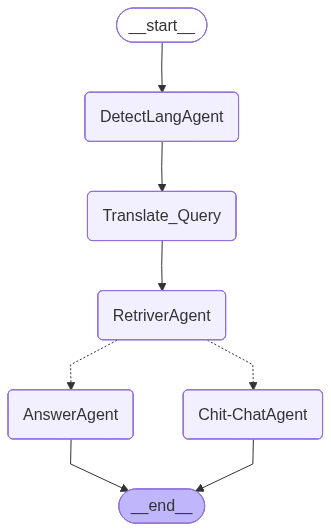

In [24]:
graph


In [25]:
graph = workflow.compile(checkpointer=MemorySaver())

In [26]:
for chunk in graph.stream(
    {"messages": [{"role": "user", "content": "اشرحلي encoder"}]},
    config={"configurable": {"thread_id": "1"}},
    stream_mode="values",
):
    for node, update in chunk.items():
        print(f"\n--- Node: {node} ---")
        for msg in update:
            msg.pretty_print()



--- Node: messages ---
================================ Human Message =================================

اشرحلي encoder

--- Node: messages ---
================================ Human Message =================================

اشرحلي encoder
================================ Human Message =================================

Explain to me encoder

--- Node: messages ---
================================ Human Message =================================

اشرحلي encoder
================================ Human Message =================================

Explain to me encoder
================================== Ai Message ==================================
Name: RetriverAgent
Tool Calls:
  retriever_tool (5f04b995-d3b7-48d4-9fd7-924de6a1d4c6)
 Call ID: 5f04b995-d3b7-48d4-9fd7-924de6a1d4c6
  Args:
    query: اشرحلي encoder
================================= Tool Message =================================
Name: retriever_tool

tion performance is typically achieved with only minimal changes to the lang

In [27]:
for chunk in graph.stream(
    {"messages": [{"role": "user", "content": "explain what is teanformer encoder"}]},
    config={"configurable": {"thread_id": "1"}},
    stream_mode="values",
):
    for node, update in chunk.items():
        print(f"\n--- Node: {node} ---")
        for msg in update:
            msg.pretty_print() 


--- Node: messages ---
================================ Human Message =================================

اشرحلي encoder
================================ Human Message =================================

Explain to me encoder
================================== Ai Message ==================================
Name: RetriverAgent
Tool Calls:
  retriever_tool (5f04b995-d3b7-48d4-9fd7-924de6a1d4c6)
 Call ID: 5f04b995-d3b7-48d4-9fd7-924de6a1d4c6
  Args:
    query: اشرحلي encoder
================================= Tool Message =================================
Name: retriever_tool

tion performance is typically achieved with only minimal changes to the language
model parameters, often limited to updates over the ﬁnal few layers of the trans-
former. Fig. 11.9 illustrates this overall approach to sequence classiﬁcation.
[CLS]entirelypredictableandlacksenergy
Bidirectional Transformer EncoderhCLS
Ei+
Ei+
Ei+
Ei+
Ei+
Ei+sentimentclassiﬁcation headWCy
Figure 11.9 Sequence classiﬁcation with a bidirec

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 36
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing


--- Node: messages ---
================================ Human Message =================================

اشرحلي encoder
================================ Human Message =================================

Explain to me encoder
================================== Ai Message ==================================
Name: RetriverAgent
Tool Calls:
  retriever_tool (5f04b995-d3b7-48d4-9fd7-924de6a1d4c6)
 Call ID: 5f04b995-d3b7-48d4-9fd7-924de6a1d4c6
  Args:
    query: اشرحلي encoder
================================= Tool Message =================================
Name: retriever_tool

tion performance is typically achieved with only minimal changes to the language
model parameters, often limited to updates over the ﬁnal few layers of the trans-
former. Fig. 11.9 illustrates this overall approach to sequence classiﬁcation.
[CLS]entirelypredictableandlacksenergy
Bidirectional Transformer EncoderhCLS
Ei+
Ei+
Ei+
Ei+
Ei+
Ei+sentimentclassiﬁcation headWCy
Figure 11.9 Sequence classiﬁcation with a bidirec

In [28]:
output = graph.invoke( {"messages": [
            {
                "role": "user",
                "content": "Which ML type is actually better?",
            }
        ]} ,  config={"configurable": {"thread_id": "1"}})


output

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 4
}
].


******************************** اشرحلي encoder +++++++++++++++++++++++++


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 2
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 8.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing 

{'messages': [HumanMessage(content='اشرحلي encoder', additional_kwargs={}, response_metadata={}, id='021a0399-9cf3-4da0-a687-ca81226e9dec'),
  HumanMessage(content='Explain to me encoder', additional_kwargs={}, response_metadata={}, id='9d929ba6-868d-4ce5-b7f0-9c98682b5ffd'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'retriever_tool', 'arguments': '{"query": "\\u0627\\u0634\\u0631\\u062d\\u0644\\u064a encoder"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, name='RetriverAgent', id='run--303698d2-e5a4-4bc6-8aa6-1d4c6dcdf236-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'اشرحلي encoder'}, 'id': '5f04b995-d3b7-48d4-9fd7-924de6a1d4c6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 124, 'output_tokens': 82, 'total_tokens': 206, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 63}}),
  ToolMe

In [29]:
graph = workflow.compile(checkpointer=MemorySaver())

output = graph.invoke( {"messages": [
            {
                "role": "user",
                "content": "types of manchine learning",
            }
        ]} ,  config={"configurable": {"thread_id": "1"}})


output

******************************** types of manchine learning +++++++++++++++++++++++++


{'messages': [HumanMessage(content='types of manchine learning', additional_kwargs={}, response_metadata={}, id='f4275b84-2c34-4d2b-bfdb-a1264b167956'),
  HumanMessage(content='types of manchine learning', additional_kwargs={}, response_metadata={}, id='6b3bbcc1-9e08-450f-9a68-6b62d51c1f25'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'retriever_tool', 'arguments': '{"query": "types of manchine learningtypes of manchine learning"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, name='RetriverAgent', id='run--31691553-3232-4597-855f-a3919091497b-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'types of manchine learningtypes of manchine learning'}, 'id': '28606d6e-9931-4ed7-9017-fea506945d66', 'type': 'tool_call'}], usage_metadata={'input_tokens': 126, 'output_tokens': 73, 'total_tokens': 199, 'input_token_details': {'cache_read': 

In [30]:
output['messages'][-1].pretty_print()

================================== Ai Message ==================================

Based on the context provided, the types of machine learning mentioned are:

*   **Transfer learning**
*   **Unsupervised learning**

The context also describes a perceptron being trained with examples to recognize differences, which is characteristic of **supervised learning**, though the term itself is not explicitly used.


In [31]:
output = graph.invoke( {"messages": [
            {
                "role": "user",
                "content": "Which ML type is actually better?",
            }
        ]} ,  config={"configurable": {"thread_id": "1"}})


output

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 30
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing

{'messages': [HumanMessage(content='types of manchine learning', additional_kwargs={}, response_metadata={}, id='f4275b84-2c34-4d2b-bfdb-a1264b167956'),
  HumanMessage(content='types of manchine learning', additional_kwargs={}, response_metadata={}, id='6b3bbcc1-9e08-450f-9a68-6b62d51c1f25'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'retriever_tool', 'arguments': '{"query": "types of manchine learningtypes of manchine learning"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, name='RetriverAgent', id='run--31691553-3232-4597-855f-a3919091497b-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'types of manchine learningtypes of manchine learning'}, 'id': '28606d6e-9931-4ed7-9017-fea506945d66', 'type': 'tool_call'}], usage_metadata={'input_tokens': 126, 'output_tokens': 73, 'total_tokens': 199, 'input_token_details': {'cache_read': 